In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import skew, kurtosis
sns.set(context='talk', style='whitegrid')
np.random.seed(8)
pd.set_option('display.max_columns', 100)

In [2]:
# === Synthetic data generator
n = 160
df = pd.DataFrame({
    'date': pd.date_range('2021-02-01', periods=n, freq='D'),
    'region': np.random.choice(['North','South','East','West'], size=n),
    'age': np.random.normal(40, 8, size=n).clip(22, 70).round(1),
    'income': np.random.lognormal(mean=10.6, sigma=0.3, size=n).round(2),
    'transactions': np.random.poisson(lam=3, size=n),
})
base = df['income'] * 0.0015 + df['transactions']*18 + np.random.normal(0, 40, size=n)
df['spend'] = np.maximum(0, base).round(2)

# inject a bit of missingness and outliers
df.loc[np.random.choice(df.index, 5, replace=False), 'income'] = np.nan
df.loc[np.random.choice(df.index, 3, replace=False), 'spend'] = np.nan
df.loc[np.random.choice(df.index, 2, replace=False), 'transactions'] = df['transactions'].max()+12
df.head()

,date,region,age,income,transactions,spend
0,2021-02-01,West,37.6,28086.81,4,73.35
1,2021-02-02,North,43.0,33034.75,1,52.37
2,2021-02-03,South,38.2,50045.39,2,131.85
3,2021-02-04,South,24.9,39467.28,4,147.58
4,2021-02-05,South,59.8,31201.65,1,86.76


In [3]:
# === Summary statistics ===
df.info(), df.isna().sum() 
desc = df[['age','income','transactions','spend']].describe().T
desc['skew'] = [skew(df[c].dropna()) for c in desc.index]
desc['kurtosis'] = [kurtosis(df[c].dropna()) for c in desc.index]
desc 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          160 non-null    datetime64[ns]
 1   region        160 non-null    object        
 2   age           160 non-null    float64       
 3   income        155 non-null    float64       
 4   transactions  160 non-null    int32         
 5   spend         157 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int32(1), object(1)
memory usage: 7.0+ KB


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,160.0,40.018750,8.458676,22.00,34.70,40.15,44.925,61.10,0.069538,-0.080125
income,155.0,41983.866323,13262.457038,17928.80,32471.53,39332.52,49697.690,87052.40,0.993336,0.918722
transactions,160.0,3.237500,2.585610,0.00,2.00,3.00,4.000,20.00,3.466078,19.984802
spend,157.0,117.291592,51.768645,0.54,77.25,119.32,153.340,280.05,0.130860,-0.084917


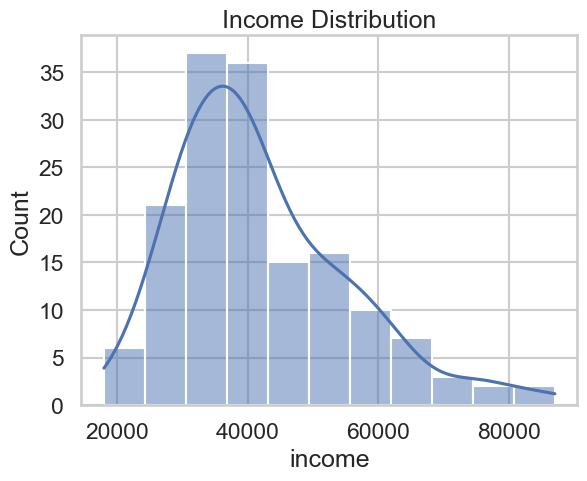

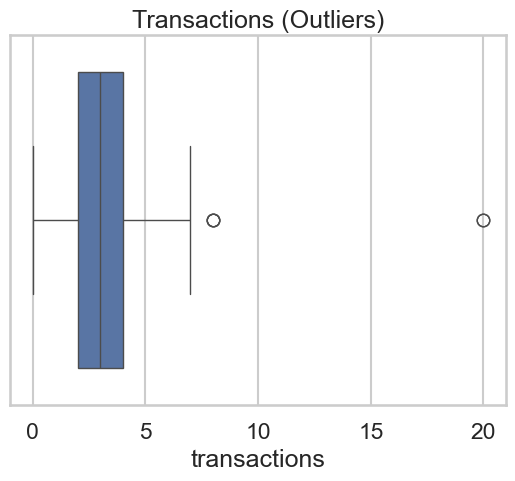

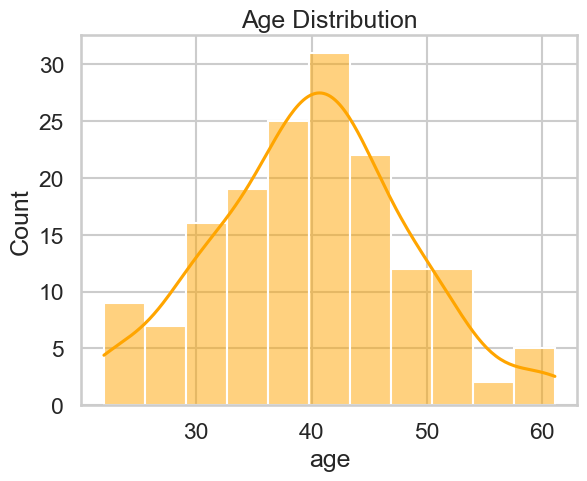

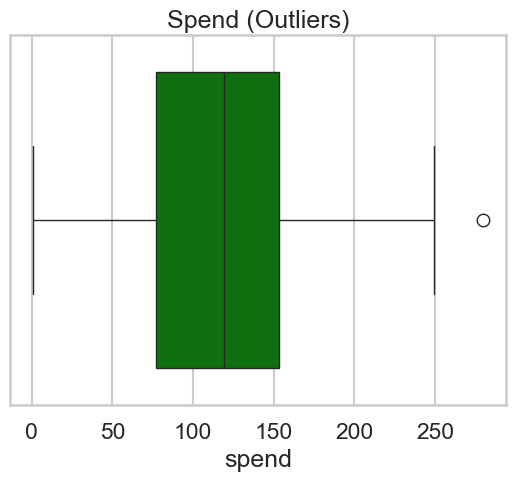

In [4]:
# === 3) Distributions (at least 3) ===
# Histogram for income
sns.histplot(df['income'], kde=True)
plt.title('Income Distribution')
plt.show()

# Boxplot for transactions
sns.boxplot(x=df['transactions'])
plt.title('Transactions (Outliers)')
plt.show()

# Histogram for age
sns.histplot(df['age'], kde=True, color='orange')
plt.title('Age Distribution')
plt.show()

# Boxplot for spend
sns.boxplot(x=df['spend'], color='green')
plt.title('Spend (Outliers)')
plt.show()

1）The distribution of income is right-skewed, with most values concentrated between 30,000 and 45,000. A few higher-income outliers are observed beyond 70,000. This suggests income variability and the need to handle skewness.
2）The boxplot shows that most transaction counts cluster between 0 and 6. However, there are several outliers with very high transaction counts, likely injected noise. These points may need special treatment during cleaning.
3）There is a positive relationship between income and spend, meaning higher income generally corresponds to higher spending. However, the relationship shows variation across regions, suggesting regional effects may play a role.
4）Spending does not show a strong linear trend with age. Younger and middle-aged groups spend similarly, while some older individuals exhibit higher variance in spending. This may indicate lifestyle or regional differences.
5）The heatmap shows strong correlation between income and spend, and moderate correlation between transactions and spend. Age has weaker relationships with other variables. These insights can guide feature selection in modeling.



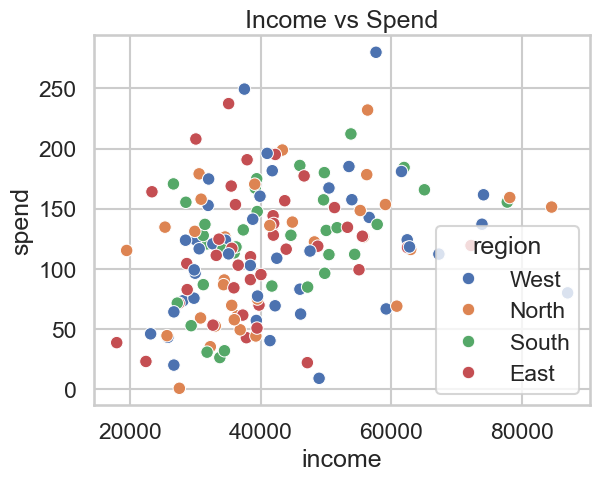

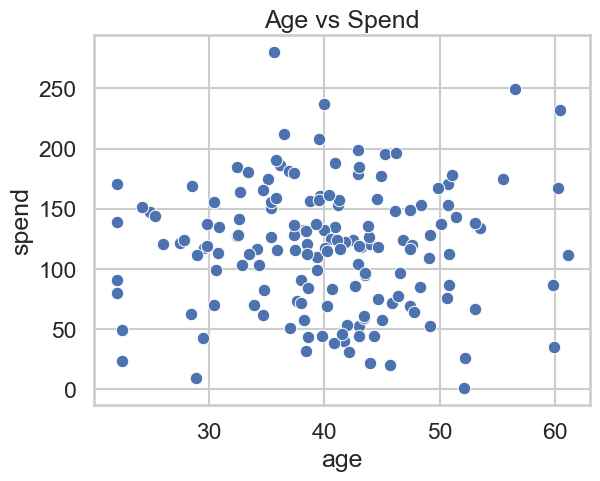

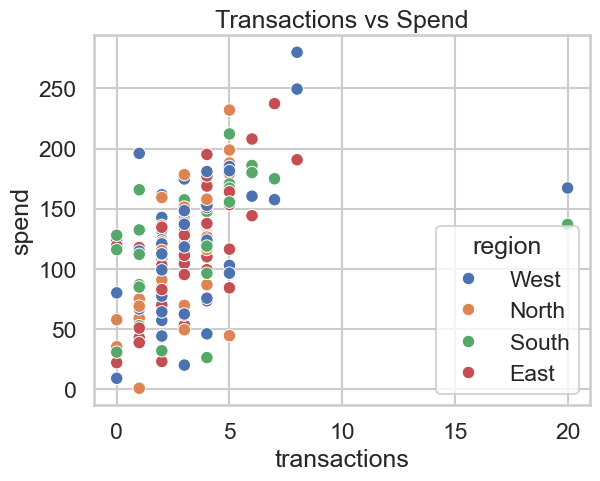

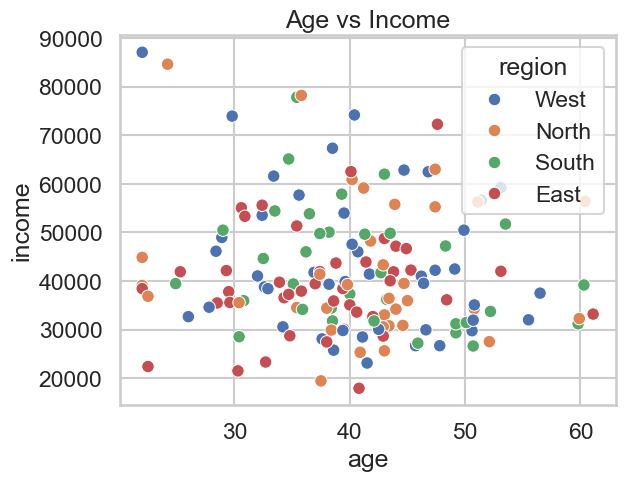

In [5]:
# === 4) Relationships (at least 2) ===
# Income vs Spend
sns.scatterplot(data=df, x='income', y='spend', hue='region')
plt.title('Income vs Spend')
plt.show()

# Age vs Spend
sns.scatterplot(data=df, x='age', y='spend')
plt.title('Age vs Spend')
plt.show()

# Transactions vs Spend
sns.scatterplot(data=df, x='transactions', y='spend', hue='region')
plt.title('Transactions vs Spend')
plt.show()

# Income vs Age
sns.scatterplot(data=df, x='age', y='income', hue='region')
plt.title('Age vs Income')
plt.show()

1）There is a clear positive trend between income and spend: higher income is generally associated with higher spending. However, the spread of points indicates that other factors, such as region, may influence spending behavior.
2）Spending does not strongly depend on age. Most age groups show similar spending patterns, though some older individuals exhibit higher variability, which may reflect lifestyle or regional effects rather than age alone.
3）Different regions display variations in spending distribution. Some regions have higher median spending, while others show wider spread. This suggests regional context may be an important predictor in modeling.
4）The correlation heatmap confirms a strong positive relationship between income and spend, and a moderate relationship between transactions and spend. Age shows weak correlations with other variables, suggesting limited predictive power.


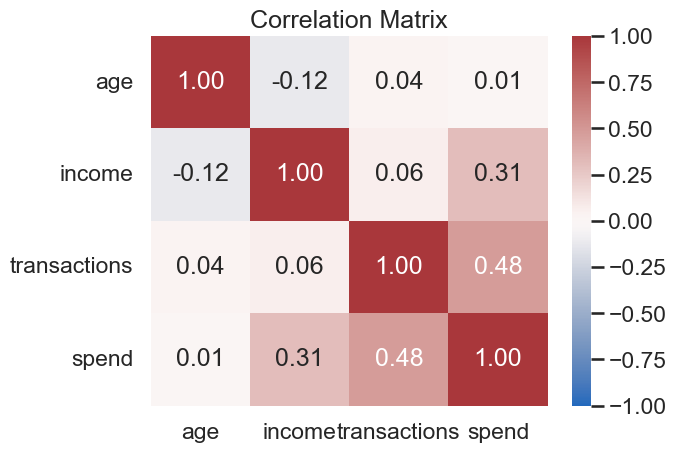

,age,income,transactions,spend
age,1.000000,-0.123160,0.037754,0.008174
income,-0.123160,1.000000,0.063573,0.307307
transactions,0.037754,0.063573,1.000000,0.480685
spend,0.008174,0.307307,0.480685,1.000000


In [6]:
# === Correlation heatmap ===
corr = df[['age','income','transactions','spend']].corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
corr

The correlation heatmap shows that income and spend are strongly correlated, confirming that higher income often leads to higher spending. Transactions also have a moderate positive correlation with spend, indicating they contribute to spending but are less dominant than income. Age has weak correlations with other variables, suggesting it may not be a strong predictor in the model.


Top 3 Insights

1)income follows a log-normal shape, with a few high-income individuals pulling up the mean. This indicates skewness, suggesting that log transformation or standardization may be necessary before modeling.

2)spend shows a positive relationship with both income and transactions. The effect of transactions appears more direct and linear, suggesting these features may be strong predictors for spend.

3)Missing values were observed in income and spend, while extreme values exist in transactions. These need to be addressed before reliable modeling can be performed.

Assumptions & Risks

Assumed that the dataset is representative and that regions are roughly balanced. Risk: regional differences may not be fully captured.

Assumed that missing values are missing at random (MCAR/MAR). If instead they are related to user behavior, imputation could introduce bias.

Assumed that the relationship between income and spend is stable, but in reality it could be influenced by external factors 

Next Steps before Modeling (Cleaning & Features)

Handle missing values: Impute income and spend appropriately 

Feature engineering:

1)Apply log transformation to income to reduce skewness.

2)Derive time-based features from date  to capture possible seasonality.

3)Encode region using one-hot encoding for modeling.